In [2]:
import sys
sys.path.append("../../..")
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
from func.iit_tpm import make_tpm, tpm_series, dis_mean
from func.grn_tpm import iit_tpm_cal

def decimal_to_binary(decimal, min_length=1):
    if min_length == 0:
        return ''
    if decimal == 0:
        return "0" if min_length == 1 else "0".zfill(min_length)
    binary = ""
    while decimal > 0:
        binary = str(decimal % 2) + binary
        decimal = decimal // 2
    # 使用 zfill 确保二进制字符串至少有 min_length 长度
    return binary.zfill(min_length)



bnet = {
    ('A', 'B'): 'w_ab',
    ('B', 'A'): 'w_ba',
    ('A', 'C'): 'w_ac',
    ('C', 'A'): 'w_ca',
    ('B', 'C'): 'w_bc',
    ('C', 'B'): 'w_cb',
    ('A', 'A'): 'w_a',
    ('B', 'B'): 'w_b',
    ('C', 'C'): 'w_c',
    ('E1', 'A'): 'w1a',
    ('E1', 'B'): 'w1b',
    ('E1', 'C'): 'w1c',
    ('E2', 'A'): 'w2a',
    ('E2', 'B'): 'w2b',
    ('E2', 'C'): 'w2c',
}

colors=["#BB4F4F", '#2A69B3', '#74B38F', '#9B76B2', "#B99523", "#27B5AF", "#1E90FF", "#87CEEB"]

# Toy example

In [3]:
import numpy as np

def cal_p(prob_distribution):
    """
    计算给定概率分布的熵。

    参数:
    prob_distribution (list 或 np.array): 概率分布，必须满足概率归一化条件（即所有概率之和为 1）。

    返回:
    float: 熵的值。
    """
    # 确保输入是 numpy 数组
    prob_distribution = np.array(prob_distribution)
    
    # 检查概率分布是否归一化
    if not np.isclose(np.sum(prob_distribution), 1.0):
        raise ValueError("概率分布未归一化，请确保所有概率之和为 1。")
    
    # 计算熵
    entropy = -np.sum(prob_distribution * np.log2(prob_distribution, where=(prob_distribution > 0)))
    
    return entropy

p = [0.7, 0.3]
cal_p(p)

0.8812908992306927

Text(0, 0.5, 'Syn')

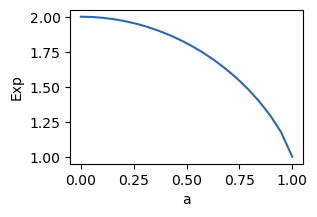

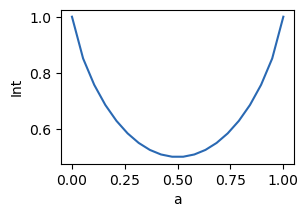

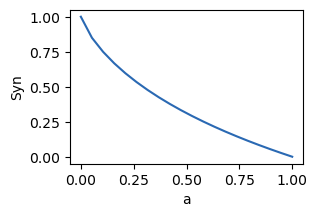

In [4]:
def cal_exp(m_list):
    in_m = m_list[0]
    for m in m_list[1:]:
        in_m = in_m + m
    in_m = in_m / len(m_list)
    n = m_list[0].shape[0]
    exp1 = 0
    for i in range(n):
        exp1 += cal_p(in_m[i,:])
    exp1 /= n
    exp2 = 0
    for m in m_list:
        exp2 += cal_p(np.mean(m,axis=0))
    exp2 /= len(m_list)
    return exp1 + exp2

def cal_int(m_list):
    int1 = 0
    n = m_list[0].shape[0]
    m_mean = np.zeros(n)
    for m in m_list:
        m_mean += np.mean(m,axis=0)
        for i in range(n):
            int1 += cal_p(m[i,:])
    m_mean /= len(m_list)
    int1 = int1 / len(m_list) / n
    int2 = cal_p(m_mean)
    return 2*np.log2(n) - int1 - int2 

def cal_syn(m_list):
    n = m_list[0].shape[0]
    return cal_exp(m_list) + cal_int(m_list) - 2*np.log2(n)

exps = []
ints = []
syns = []
for i in np.linspace(0,1,20):
    m1 = np.array([[i,1-i],[1,0]])
    m2 = np.array([[1-i,i],[0,1]])
    exps.append(cal_exp([m1, m2]))
    ints.append(cal_int([m1, m2]))
    syns.append(cal_syn([m1, m2]))

plt.figure(figsize=(3,2))
plt.plot(np.linspace(0,1,20), exps, color=colors[1])
plt.xlabel('a')
plt.ylabel('Exp')
plt.figure(figsize=(3,2))
plt.plot(np.linspace(0,1,20), ints, color=colors[1])
plt.xlabel('a')
plt.ylabel('Int')
plt.figure(figsize=(3,2))
plt.plot(np.linspace(0,1,20), syns, color=colors[1])
plt.xlabel('a')
plt.ylabel('Syn')

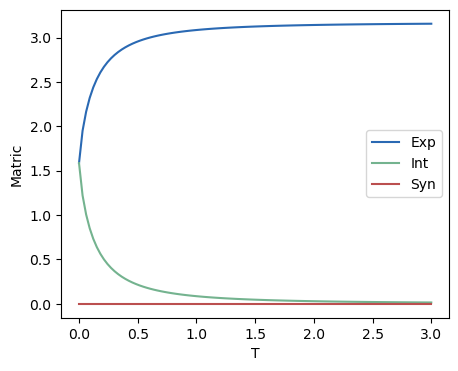

In [16]:
init_m = np.array([[1,0,0],[0,1,0],[0,0,1]])

def add_noise(mat, k):
    mat = mat + k
    # 对每行进行归一化
    row_sums = mat.sum(axis=1, keepdims=True)  # 计算每行的和
    normalized_matrix = mat / row_sums  # 归一化
    return normalized_matrix

exps = []
ints = []
syns = []
for k in np.linspace(0,3,100):
    mat1 = add_noise(init_m, k)
    mat2 = add_noise(init_m, k)
    mat3 = add_noise(init_m, k)
    exps.append(cal_exp([mat1, mat2, mat3]))
    ints.append(cal_int([mat1, mat2, mat3]))
    syns.append(cal_syn([mat1, mat2, mat3]))

plt.figure(figsize=(5,4))
plt.plot(np.linspace(0,3,100), exps, color=colors[1], label='Exp')
plt.plot(np.linspace(0,3,100), ints, color=colors[2], label='Int')
plt.plot(np.linspace(0,3,100), syns, color=colors[0], label='Syn')
plt.xlabel('T')
plt.ylabel('Matric')
plt.legend()

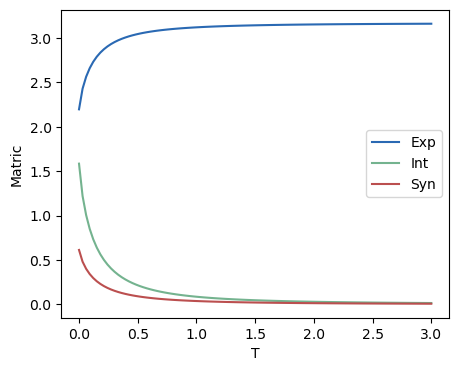

In [15]:
init_m = np.array([[1,0,0],[0,1,0],[0,0,1]])
init_m1 = np.array([[0,1,0],[1,0,0],[0,0,1]])

exps = []
ints = []
syns = []
for k in np.linspace(0,3,100):
    mat1 = add_noise(init_m, k)
    mat2 = add_noise(init_m1, k)
    mat3 = add_noise(init_m, k)
    exps.append(cal_exp([mat1, mat2, mat3]))
    ints.append(cal_int([mat1, mat2, mat3]))
    syns.append(cal_syn([mat1, mat2, mat3]))

plt.figure(figsize=(5,4))
plt.plot(np.linspace(0,3,100), exps, color=colors[1], label='Exp')
plt.plot(np.linspace(0,3,100), ints, color=colors[2], label='Int')
plt.plot(np.linspace(0,3,100), syns, color=colors[0], label='Syn')
plt.xlabel('T')
plt.ylabel('Matric')
plt.legend()

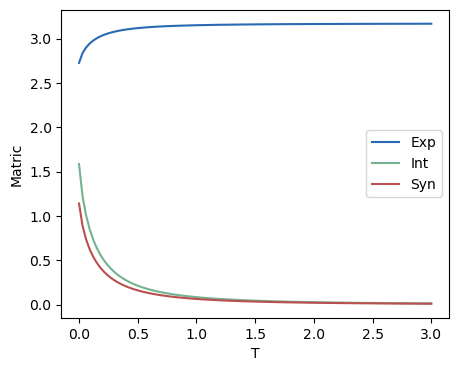

In [18]:
init_m = np.array([[1,0,0],[0,1,0],[0,0,1]])
init_m1 = np.array([[0,1,0],[1,0,0],[0,0,1]])
init_m2 = np.array([[1,0,0],[0,0,1],[0,1,0]])

exps = []
ints = []
syns = []
for k in np.linspace(0,3,100):
    mat1 = add_noise(init_m, k)
    mat2 = add_noise(init_m1, k)
    mat3 = add_noise(init_m2, k)
    exps.append(cal_exp([mat1, mat2, mat3]))
    ints.append(cal_int([mat1, mat2, mat3]))
    syns.append(cal_syn([mat1, mat2, mat3]))

plt.figure(figsize=(5,4))
plt.plot(np.linspace(0,3,100), exps, color=colors[1], label='Exp')
plt.plot(np.linspace(0,3,100), ints, color=colors[2], label='Int')
plt.plot(np.linspace(0,3,100), syns, color=colors[0], label='Syn')
plt.xlabel('T')
plt.ylabel('Matric')
plt.legend()

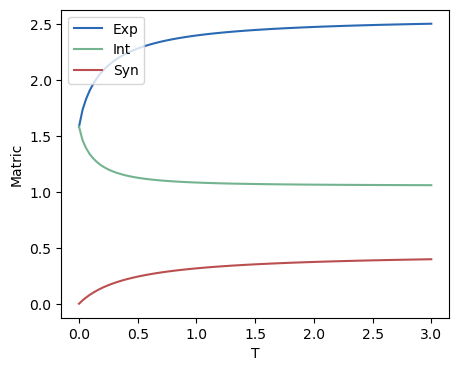

In [21]:
init_m = np.array([[1,0,0],[0,1,0],[0,0,1]])

lens = 3
exps = []
ints = []
syns = []
for k in np.linspace(0,lens,100):
    mat1 = add_noise(init_m, k)
    mat2 = init_m
    mat3 = init_m
    exps.append(cal_exp([mat1, mat2, mat3]))
    ints.append(cal_int([mat1, mat2, mat3]))
    syns.append(cal_syn([mat1, mat2, mat3]))

plt.figure(figsize=(5,4))
plt.plot(np.linspace(0,lens,100), exps, color=colors[1], label='Exp')
plt.plot(np.linspace(0,lens,100), ints, color=colors[2], label='Int')
plt.plot(np.linspace(0,lens,100), syns, color=colors[0], label='Syn')
plt.xlabel('T')
plt.ylabel('Matric')
plt.legend()

<Axes: >

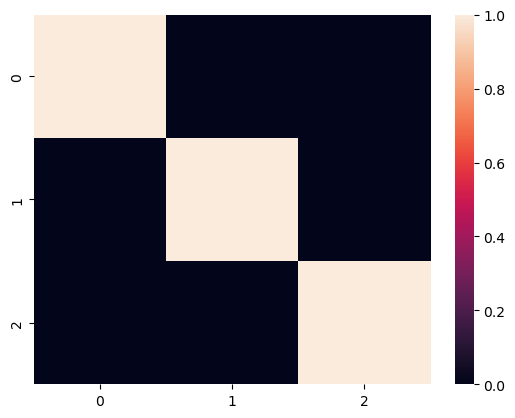

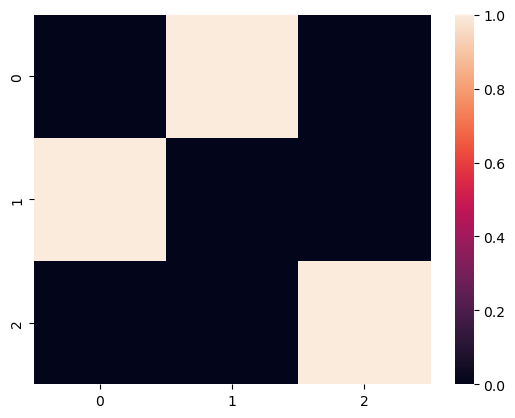

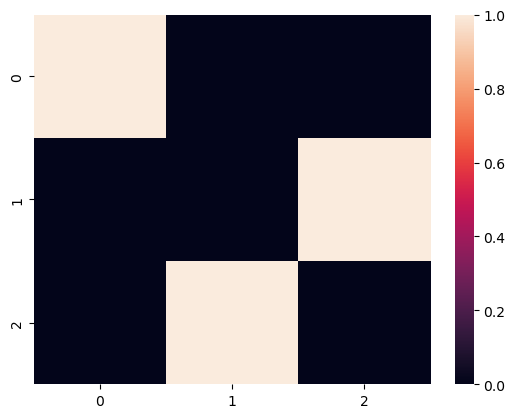

In [17]:
import seaborn as sns

init_m = np.array([[1,0,0],[0,1,0],[0,0,1]])
init_m1 = np.array([[0,1,0],[1,0,0],[0,0,1]])
init_m2 = np.array([[1,0,0],[0,0,1],[0,1,0]])
sns.heatmap(init_m)

plt.figure()
sns.heatmap(init_m1)

plt.figure()
sns.heatmap(init_m2)

Text(0, 0.5, 'Syn')

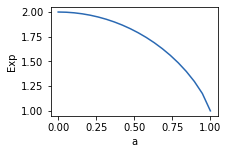

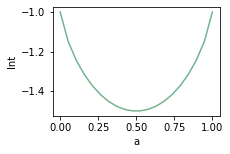

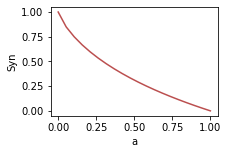

In [28]:
a = np.linspace(0,1,20)
colors = ["#BB4F4F", '#2A69B3', '#74B38F', '#9B76B2', "#B99523", "#27B5AF", "#1E90FF", "#87CEEB"]
exps = [1 + cal_p([(1+i)/2,(1-i)/2]) for i in a]
ints = [- 1 - 0.5* cal_p([i, 1-i]) for i in a]
plt.figure(figsize=(3,2))
plt.plot(a, exps, color=colors[1])
plt.xlabel('a')
plt.ylabel('Exp')
plt.figure(figsize=(3,2))
plt.plot(a, ints, color=colors[2])
plt.xlabel('a')
plt.ylabel('Int')
plt.figure(figsize=(3,2))
plt.plot(a, np.array(ints)+np.array(exps), color=colors[0])
plt.xlabel('a')
plt.ylabel('Syn')

Text(0, 0.5, 'Syn')

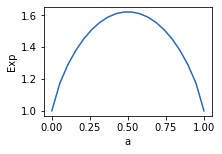

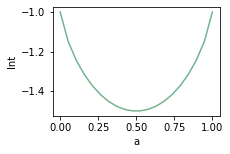

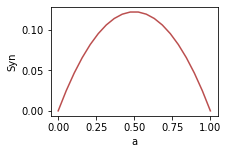

In [30]:
a = np.linspace(0,1,20)
colors = ["#BB4F4F", '#2A69B3', '#74B38F', '#9B76B2', "#B99523", "#27B5AF", "#1E90FF", "#87CEEB"]
exps = [cal_p([(1+i)/2,(1-i)/2]) + cal_p([(i)/2,(2-i)/2]) for i in a]
ints = [- 1 - 0.5* cal_p([i, 1-i]) for i in a]
plt.figure(figsize=(3,2))
plt.plot(a, exps, color=colors[1])
plt.xlabel('a')
plt.ylabel('Exp')
plt.figure(figsize=(3,2))
plt.plot(a, ints, color=colors[2])
plt.xlabel('a')
plt.ylabel('Int')
plt.figure(figsize=(3,2))
plt.plot(a, np.array(ints)+np.array(exps), color=colors[0])
plt.xlabel('a')
plt.ylabel('Syn')


<ipython-input-19-8a111b3726ac>:21: RuntimeWarning: invalid value encountered in multiply
  entropy = -np.sum(prob_distribution * np.log2(prob_distribution, where=(prob_distribution > 0)))


Text(0, 0.5, 'Syn')

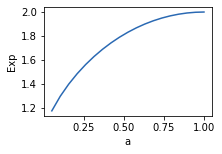

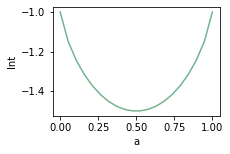

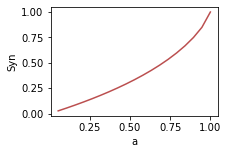

In [31]:
a = np.linspace(0,1,20)
colors = ["#BB4F4F", '#2A69B3', '#74B38F', '#9B76B2', "#B99523", "#27B5AF", "#1E90FF", "#87CEEB"]
exps = [1 + cal_p([(i)/2,(2-i)/2]) for i in a]
ints = [- 1 - 0.5* cal_p([i, 1-i]) for i in a]
plt.figure(figsize=(3,2))
plt.plot(a, exps, color=colors[1])
plt.xlabel('a')
plt.ylabel('Exp')
plt.figure(figsize=(3,2))
plt.plot(a, ints, color=colors[2])
plt.xlabel('a')
plt.ylabel('Int')
plt.figure(figsize=(3,2))
plt.plot(a, np.array(ints)+np.array(exps), color=colors[0])
plt.xlabel('a')
plt.ylabel('Syn')

Text(0, 0.5, 'Syn')

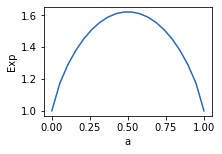

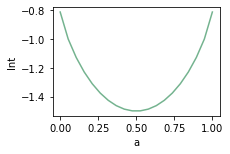

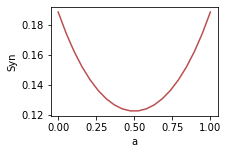

In [34]:
a = np.linspace(0,1,20)
colors = ["#BB4F4F", '#2A69B3', '#74B38F', '#9B76B2', "#B99523", "#27B5AF", "#1E90FF", "#87CEEB"]
exps = [cal_p([(1+i)/2,(1-i)/2]) + cal_p([(i)/2,(2-i)/2]) for i in a]
ints = [- cal_p([0.75-0.5*i, 0.25+0.5*i]) - 0.5* cal_p([i, 1-i]) for i in a]
plt.figure(figsize=(3,2))
plt.plot(a, exps, color=colors[1])
plt.xlabel('a')
plt.ylabel('Exp')
plt.figure(figsize=(3,2))
plt.plot(a, ints, color=colors[2])
plt.xlabel('a')
plt.ylabel('Int')
plt.figure(figsize=(3,2))
plt.plot(a, np.array(ints)+np.array(exps), color=colors[0])
plt.xlabel('a')
plt.ylabel('Syn')


# 同时调节k和w

In [5]:
from tqdm import tqdm
n = 50
syn_arr = np.zeros([n, n])
un_sys_arr = np.zeros([n, n])
un_en_arr = np.zeros([n, n])
expand_arr = np.zeros([n, n])
intro_arr = np.zeros([n, n])
w_axis = np.linspace(0, 1, n)
T_axis = np.linspace(0.05, 1, n)
k_axis = [1/t for t in T_axis]#np.linspace(1, 16, n)
for w_id,w in tqdm(enumerate(w_axis)):
    w1 = 0.1*(1 - w)
    w2 = 1.9*(1 - w)
    ww = {
        'w_ab': w,
        'w_ba': 0,
        'w_ac': 0,
        'w_ca': w,
        'w_bc': w,
        'w_cb': 0,
        'w_a': w,
        'w_b': w,
        'w_c': w,
        'w1a': w1,
        'w1b': w1,
        'w1c': w1,
        'w2a': w2,
        'w2b': w2,
        'w2c': w2
    }
    for k_id,k in enumerate(k_axis):
        tpm, tpm_v = make_tpm(bnet, ww, k=k)
        un_sys, un_en, syn, expansive, introverted, tpm_dic = iit_tpm_cal(tpm_v, mech_size=3, en_size=2, dis=False) 
        syn_arr[k_id, w_id] = syn
        un_sys_arr[k_id, w_id] = un_sys
        un_en_arr[k_id, w_id] = un_en
        expand_arr[k_id, w_id] = expansive
        intro_arr[k_id, w_id] = introverted



50it [02:54,  3.49s/it]


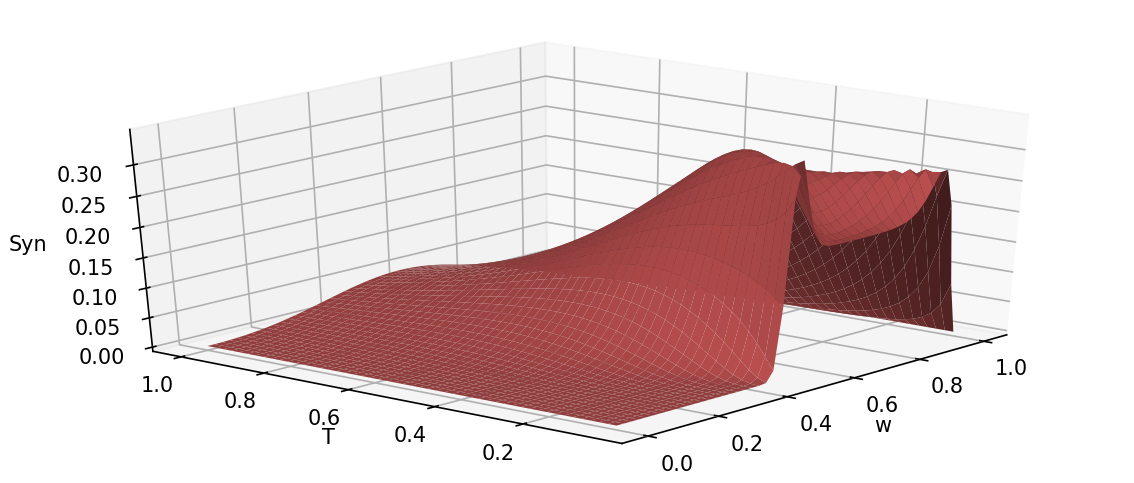

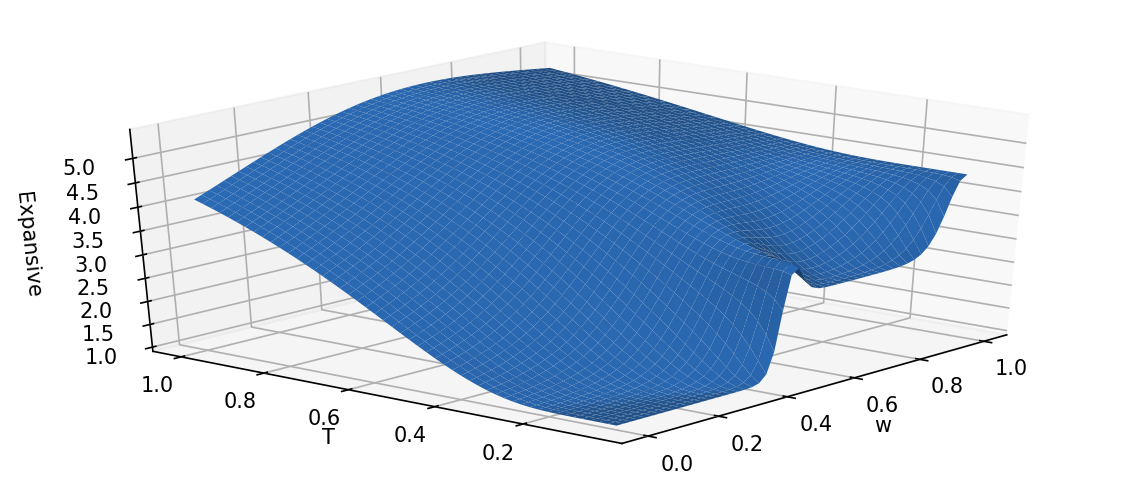

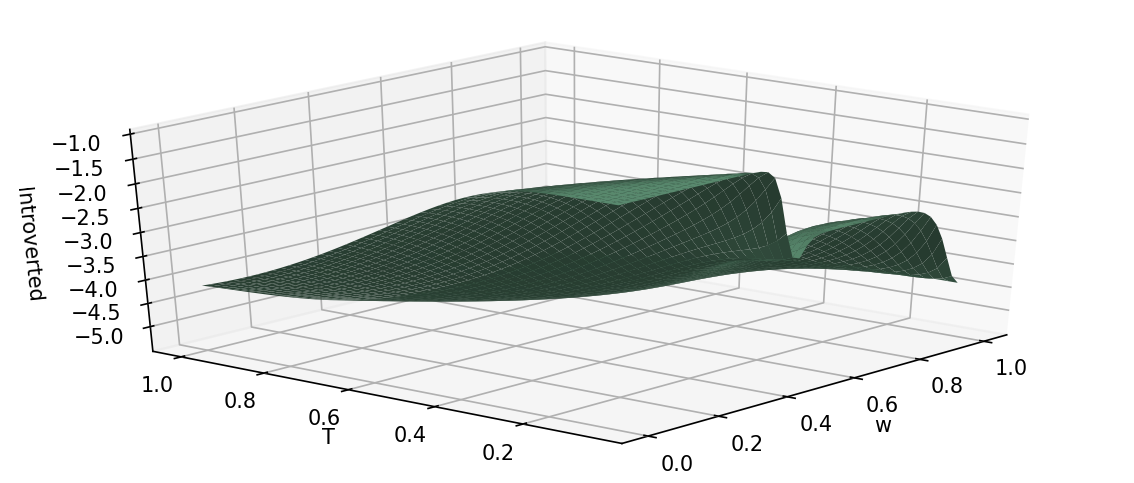

In [19]:

import matplotlib.pyplot as plt
import numpy as np

colors = ["#BB4F4F", '#2A69B3', '#74B38F', '#9B76B2', "#B99523", "#27B5AF", "#1E90FF", "#87CEEB"]

def plot_3d(axis1, axis2, measure, name='', color_index=0):
    fig = plt.figure(figsize=(9.5, 4), dpi=150)
    ax = fig.add_subplot(111, projection='3d')
    data = measure
    X, Y = np.meshgrid(axis1, axis2)
    Z = data
    surf = ax.plot_surface(X, Y, Z, color=colors[color_index])
    ax.set_xlabel('w')
    ax.set_ylabel('T')
    ax.set_zlabel(name)
    ax.view_init(elev=None, azim=220)
    plt.show()
    return

plot_3d(w_axis, T_axis, syn_arr, "Syn", 0)
plot_3d(w_axis, T_axis, expand_arr, "Expansive", 1)
plot_3d(w_axis, T_axis, intro_arr, "Introverted", 2)

# 最佳噪音实验复现

100%|██████████| 50/50 [00:04<00:00, 12.18it/s]


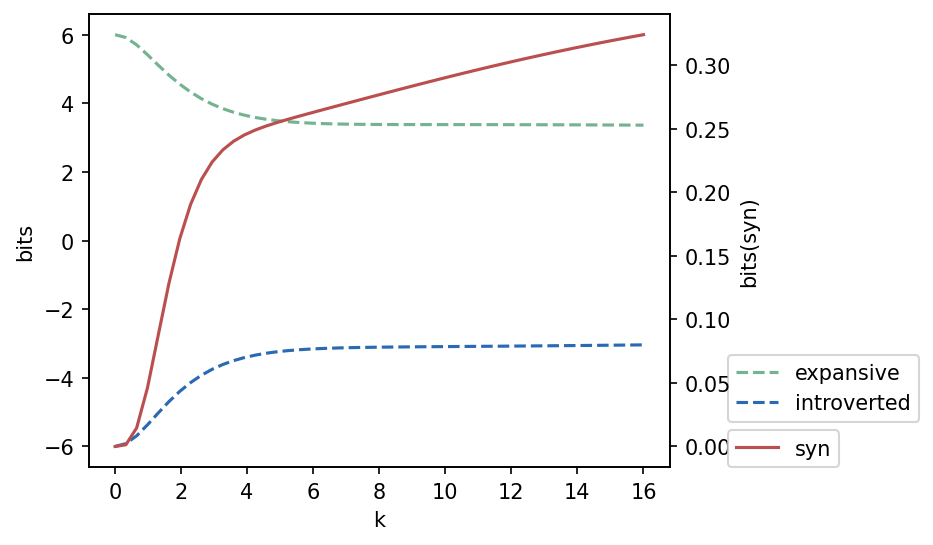

In [11]:
from tqdm import tqdm
colors = ["#BB4F4F", '#2A69B3', '#74B38F', '#9B76B2', "#B99523", "#27B5AF", "#1E90FF", "#87CEEB"]
w = 0.5
w1 = 0.1*(1 - w)
w2 = 1.9*(1 - w)
ww = {
    'w_ab': w,
    'w_ba': 0,
    'w_ac': 0,
    'w_ca': w,
    'w_bc': w,
    'w_cb': 0,
    'w_a': w,
    'w_b': w,
    'w_c': w,
    'w1a': w1,
    'w1b': w1,
    'w1c': w1,
    'w2a': w2,
    'w2b': w2,
    'w2c': w2
}

syn_list = []
expan_list = []
intro_list = []
k_axis = np.linspace(0.01, 16, 50)
for k in tqdm(k_axis):
    tpm, tpm_v = make_tpm(bnet, ww, k=k)
    un_sys, un_en, syn, expansive, introverted, tpm_dic = iit_tpm_cal(tpm_v, mech_size=3, en_size=2, dis=False) 
    syn_list.append(syn)
    expan_list.append(expansive)
    intro_list.append(introverted)
    
plt.figure(figsize=(5,4),dpi=150)

# 绘制第一条线，关联到左边的 y 轴
ax1 = plt.gca()  # 获取当前坐标轴
plt.plot(k_axis, expan_list, label='expansive', linestyle="--", color=colors[2])
plt.plot(k_axis, intro_list, label="introverted", linestyle='--', color=colors[1])
plt.legend(loc=[1.1, 0.1])
# 绘制第二条线，关联到右边的 y 轴
ax2 = ax1.twinx()  # 创建与 ax1 共享 x 轴的新坐标轴
plt.plot(k_axis, syn_list, label='syn', color=colors[0])

plt.xlabel('k')

# 设置左边 y 轴的标签
ax1.set_ylabel('bits')  

# 设置右边 y 轴的标签
ax2.set_ylabel('bits(syn)')  
ax1.set_xlabel('k')
ax2.set_xlabel('k')
plt.legend(loc=[1.1, 0])
plt.show()

# 不同系统结构应对环境变化

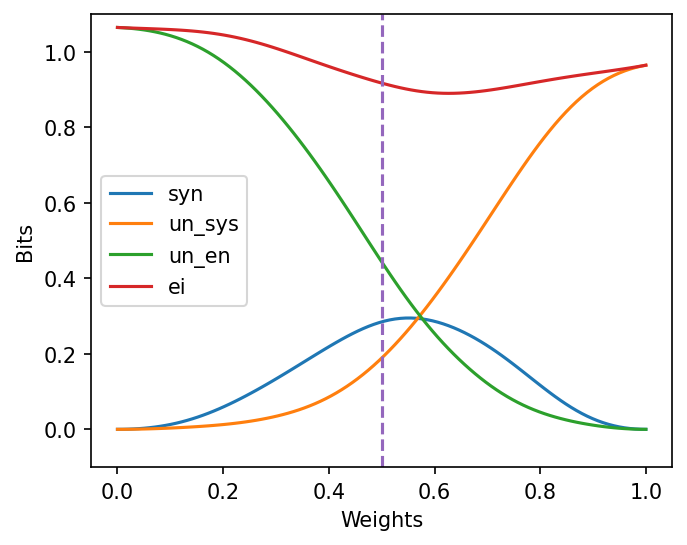

In [20]:
steps = 10
k=2
ei_list = []
syn_list = []
un_sys_list = []
un_en_list = []
w_axis = np.linspace(0, 1, 100)
for w in w_axis:
    w1 = 1 - w 
    w2 = 2 - 2*w
    ww = {
            'w_ab': w,
            'w_ba': w,
            'w_ac': w,
            'w_ca': w,
            'w_bc': w,
            'w_cb': w,
            'w_a': w,
            'w_b': w,
            'w_c': w,
            'w1a': w1,
            'w1b': w1,
            'w1c': w1,
            'w2a': w2,
            'w2b': w2,
            'w2c': w2
        }

    tpm, tpm_v = make_tpm(bnet, ww, k=k)
    un_sys, un_en, syn, tpm_dic = iit_tpm_cal(tpm_v, mech_size=3, en_size=2) 
    syn_list.append(syn)
    un_sys_list.append(un_sys)
    un_en_list.append(un_en)
    ei_list.append(syn+un_sys+un_en)
    
plt.figure(figsize=(5,4),dpi=150)
plt.plot(w_axis, syn_list, label='syn')
plt.plot(w_axis, un_sys_list, label="un_sys")
plt.plot(w_axis, un_en_list, label="un_en")
plt.plot(w_axis, ei_list, label="ei")
plt.plot([0.5,0.5], [-0.1,1.1], linestyle='--')
plt.ylim([-0.1,1.1])
plt.xlabel('Weights')
plt.ylabel('Bits')
plt.legend()

# plt.figure(figsize=(5,4),dpi=150)
# plt.plot(w_axis, un_sys_list, label="un_sys")
# plt.xlabel('weights')
# plt.ylabel('bits')
# plt.legend()
#un_sys, un_en, syn = serie_plot(bnet, w, k, steps, seeds=1)

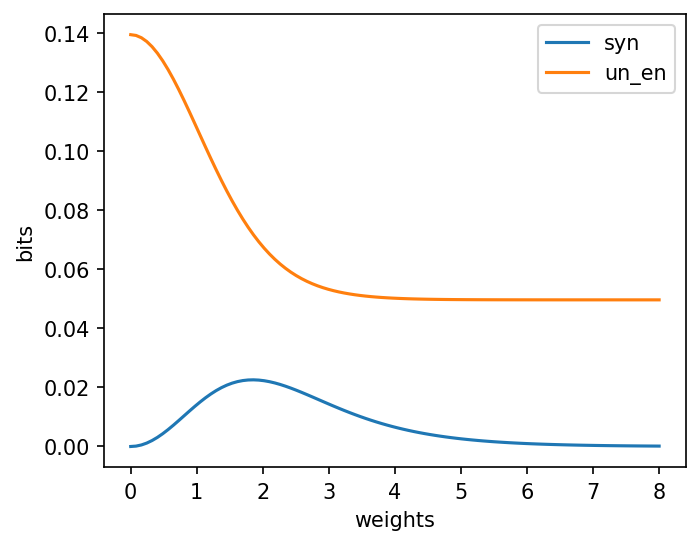

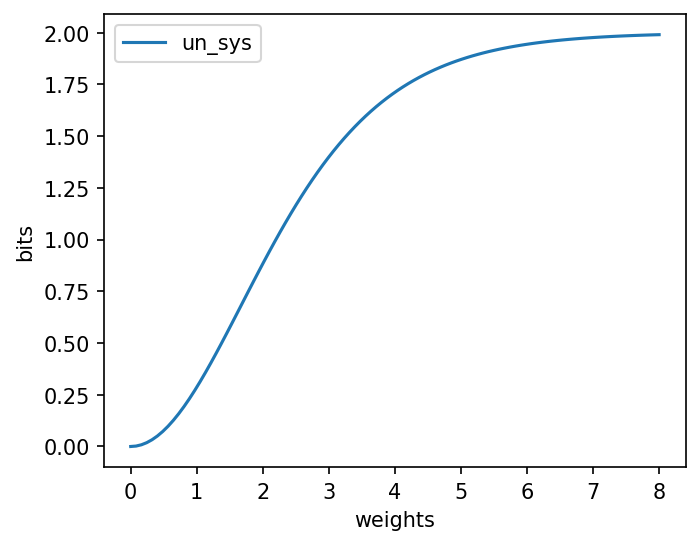

In [33]:
steps = 10
k=1
ww = {
    'w_ab': 0,
    'w_ba': 0,
    'w_ac': 0,
    'w_ca': 0,
    'w_bc': 0,
    'w_cb': 0,
    'w_a': 0,
    'w_b': 0,
    'w_c': 0,
    'w1a': 0.5,
    'w1b': 0.5,
    'w1c': 0.5,
    'w2a': 0.2,
    'w2b': 0.2,
    'w2c': 0.2
}



syn_list = []
un_sys_list = []
un_en_list = []
w_axis = np.linspace(0, 8, 100)
for w in w_axis:
    ww['w_ab'] = w
    ww['w_bc'] = w
#     ww['w_c'] = w
    tpm, tpm_v = make_tpm(bnet, ww, k=k)
    un_sys, un_en, syn, tpm_dic = iit_tpm_cal(tpm_v, mech_size=3, en_size=2) 
    syn_list.append(syn)
    un_sys_list.append(un_sys)
    un_en_list.append(un_en)
    
plt.figure(figsize=(5,4),dpi=150)
plt.plot(w_axis, syn_list, label='syn')
plt.plot(w_axis, un_en_list, label="un_en")
plt.xlabel('weights')
plt.ylabel('bits')
plt.legend()

plt.figure(figsize=(5,4),dpi=150)
plt.plot(w_axis, un_sys_list, label="un_sys")
plt.xlabel('weights')
plt.ylabel('bits')
plt.legend()

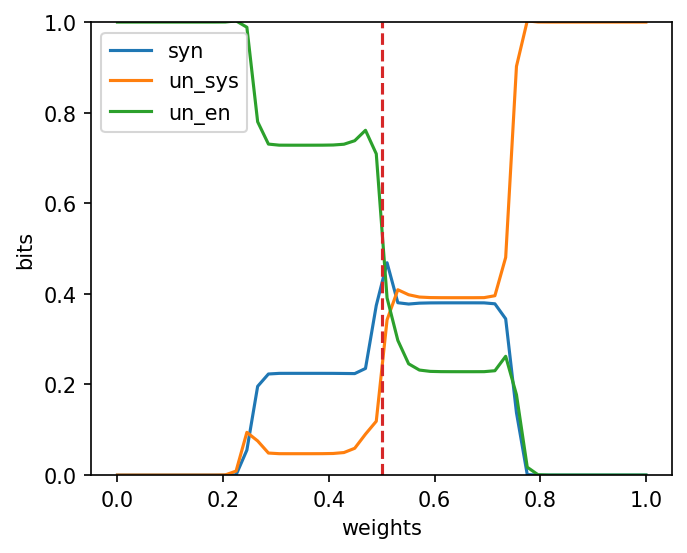

In [173]:
k=40
syn_list = []
un_sys_list = []
un_en_list = []
w_axis = np.linspace(0, 1, 50)
for w in w_axis:
    w1 = 1 - w
    w2 = 2 - 2*w
    ww = {
        'w_ab': w,
        'w_ba': w,
        'w_ac': w,
        'w_ca': w,
        'w_bc': w,
        'w_cb': w,
        'w_a': w,
        'w_b': w,
        'w_c': w,
        'w1a': w1,
        'w1b': w1,
        'w1c': w1,
        'w2a': w2,
        'w2b': w2,
        'w2c': w2
    }
    tpm, tpm_v = make_tpm(bnet, ww, k=k)
    un_sys, un_en, syn, tpm_dic = iit_tpm_cal(tpm_v, mech_size=3, en_size=2) 
    syn_list.append(syn)
    un_sys_list.append(un_sys)
    un_en_list.append(un_en)
    
plt.figure(figsize=(5,4),dpi=150)
plt.plot(w_axis, syn_list, label='syn')
plt.plot(w_axis, un_sys_list, label="un_sys")
plt.plot(w_axis, un_en_list, label="un_en")
plt.plot([0.5,0.5], [0,1], linestyle='--')
plt.xlabel('weights')
plt.ylabel('bits')
plt.ylim([0,1])
plt.legend()

# plt.figure(figsize=(5,4),dpi=150)
# plt.plot(w_axis, un_sys_list, label="un_sys")
# plt.xlabel('weights')
# plt.ylabel('bits')
# plt.legend()

# 系统与环境规模的变化

In [2]:
bnet5 = {
    ('A', 'B'): 'w_ab',
    ('B', 'A'): 'w_ba',
    ('A', 'C'): 'w_ac',
    ('C', 'A'): 'w_ca',
    ('A', 'D'): 'w_ad',
    ('D', 'A'): 'w_da',
    ('A', 'E'): 'w_ae',
    ('E', 'A'): 'w_ea',
    ('B', 'C'): 'w_bc',
    ('C', 'B'): 'w_cb',
    ('B', 'D'): 'w_bd',
    ('D', 'B'): 'w_db',
    ('B', 'E'): 'w_be',
    ('E', 'B'): 'w_eb',
    ('C', 'D'): 'w_cd',
    ('D', 'C'): 'w_dc',
    ('C', 'E'): 'w_ce',
    ('E', 'C'): 'w_ec',
    ('D', 'E'): 'w_de',
    ('E', 'D'): 'w_ed',
    ('A', 'A'): 'w_a',
    ('B', 'B'): 'w_b',
    ('C', 'C'): 'w_c',
    ('D', 'D'): 'w_d',
    ('E', 'E'): 'w_e',
    ('Q1', 'A'): 'w1a',
    ('Q1', 'B'): 'w1b',
    ('Q1', 'C'): 'w1c',
    ('Q1', 'D'): 'w1d',
    ('Q1', 'E'): 'w1e',
    ('Q2', 'A'): 'w2a',
    ('Q2', 'B'): 'w2b',
    ('Q2', 'C'): 'w2c',
    ('Q2', 'D'): 'w2d',
    ('Q2', 'E'): 'w2e',
    ('Q3', 'A'): 'w3a',
    ('Q3', 'B'): 'w3b',
    ('Q3', 'C'): 'w3c',
    ('Q3', 'D'): 'w3d',
    ('Q3', 'E'): 'w3e',
}

bnet4 = {
    ('A', 'B'): 'w_ab',
    ('B', 'A'): 'w_ba',
    ('A', 'C'): 'w_ac',
    ('C', 'A'): 'w_ca',
    ('A', 'D'): 'w_ad',
    ('D', 'A'): 'w_da',
    ('B', 'C'): 'w_bc',
    ('C', 'B'): 'w_cb',
    ('B', 'D'): 'w_bd',
    ('D', 'B'): 'w_db',
    ('C', 'D'): 'w_cd',
    ('D', 'C'): 'w_dc',
    ('A', 'A'): 'w_a',
    ('B', 'B'): 'w_b',
    ('C', 'C'): 'w_c',
    ('D', 'D'): 'w_d',
    ('Q1', 'A'): 'w1a',
    ('Q1', 'B'): 'w1b',
    ('Q1', 'C'): 'w1c',
    ('Q1', 'D'): 'w1d',
    ('Q2', 'A'): 'w2a',
    ('Q2', 'B'): 'w2b',
    ('Q2', 'C'): 'w2c',
    ('Q2', 'D'): 'w2d',
    ('Q3', 'A'): 'w3a',
    ('Q3', 'B'): 'w3b',
    ('Q3', 'C'): 'w3c',
    ('Q3', 'D'): 'w3d',
}

bnet3 = {
    ('A', 'B'): 'w_ab',
    ('B', 'A'): 'w_ba',
    ('A', 'C'): 'w_ac',
    ('C', 'A'): 'w_ca',
    ('B', 'C'): 'w_bc',
    ('C', 'B'): 'w_cb',
    ('A', 'A'): 'w_a',
    ('B', 'B'): 'w_b',
    ('C', 'C'): 'w_c',
    ('Q1', 'A'): 'w1a',
    ('Q1', 'B'): 'w1b',
    ('Q1', 'C'): 'w1c',
    ('Q2', 'A'): 'w2a',
    ('Q2', 'B'): 'w2b',
    ('Q2', 'C'): 'w2c',
    ('Q3', 'A'): 'w3a',
    ('Q3', 'B'): 'w3b',
    ('Q3', 'C'): 'w3c',
}

In [141]:
n = 50
syn_arr = np.zeros([n, n])
un_sys_arr = np.zeros([n, n])
un_en_arr = np.zeros([n, n])
w_axis = np.linspace(0, 1, n)
k_axis = np.linspace(0, 16, n)
for w_id,w in enumerate(w_axis):
    w2 = 1 - w
    ww = {
        'w_ab': w,
        'w_ba': w,
        'w_ac': w,
        'w_ca': w,
        'w_bc': w,
        'w_cb': w,
        'w_a': w,
        'w_b': w,
        'w_c': w,
        'w1a': w2,
        'w1b': w2,
        'w1c': w2,
        'w2a': w2,
        'w2b': w2,
        'w2c': w2,
        'w3a': w2,
        'w3b': w2,
        'w3c': w2,
    }
    for k_id,k in enumerate(k_axis):
        tpm, tpm_v = make_tpm(bnet3, ww, k=k)
        un_sys, un_en, syn, tpm_dic = iit_tpm_cal(tpm_v, mech_size=3, en_size=3) 
        syn_arr[k_id, w_id] = syn
        un_sys_arr[k_id, w_id] = un_sys
        un_en_arr[k_id, w_id] = un_en

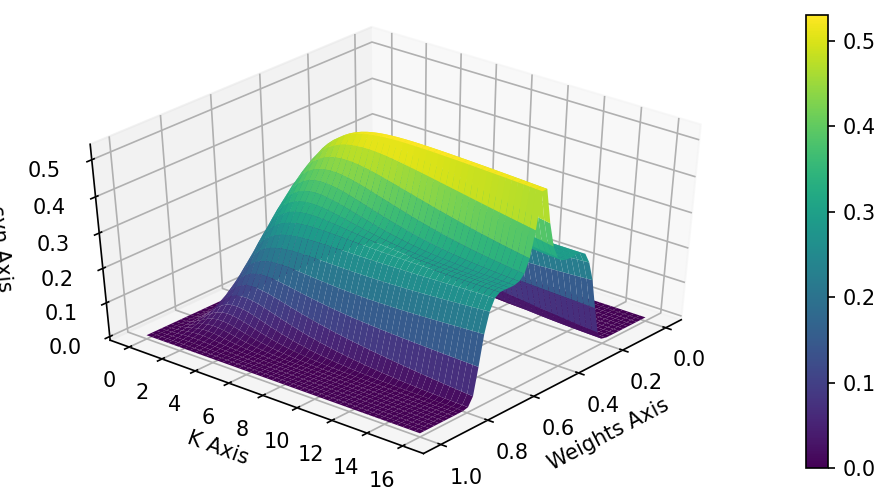

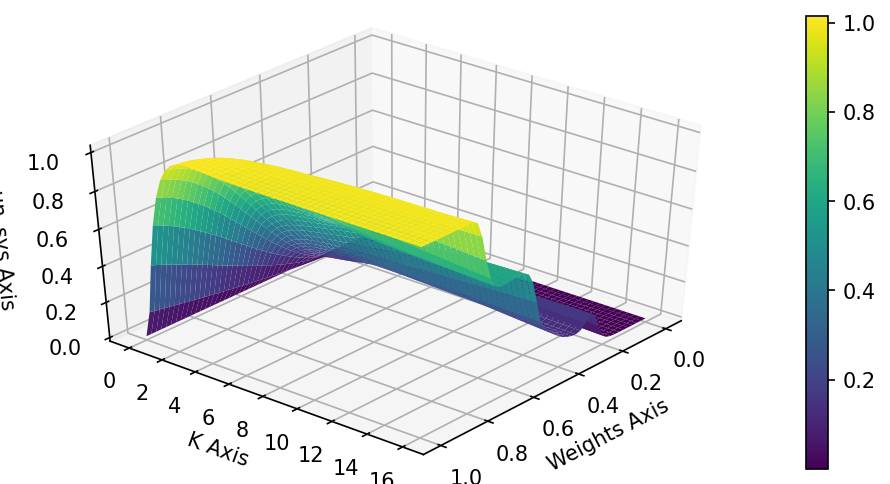

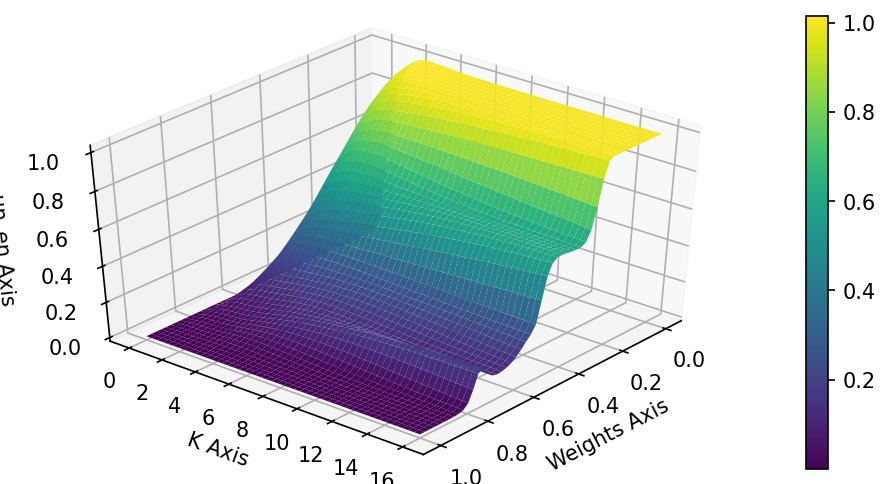

In [142]:
def plot_3d(axis1, axis2, measure, name=''):
    # 创建一个新的figure
    fig = plt.figure(figsize=(8,4), dpi=150)
    ax = fig.add_subplot(111, projection='3d')
    data = measure
    X, Y = np.meshgrid(axis1, axis2)
    Z = data
    surf = ax.plot_surface(X, Y, Z, cmap='viridis')
    fig.colorbar(surf)
    ax.set_xlabel('Weights Axis')
    ax.set_ylabel('K Axis')
    ax.set_zlabel(name + ' Axis')
    ax.view_init(elev=40, azim=40)
    plt.show()
    return

plot_3d(w_axis, k_axis, syn_arr, "syn")
plot_3d(w_axis, k_axis, un_sys_arr, "un_sys")
plot_3d(w_axis, k_axis, un_en_arr, "un_en")

In [3]:
n = 50
syn_arr = np.zeros([n, n])
un_sys_arr = np.zeros([n, n])
un_en_arr = np.zeros([n, n])
w_axis = np.linspace(0, 1, n)
k_axis = np.linspace(0, 16, n)
for w_id,w in enumerate(w_axis):
    w2 = 1 - w
    ww = {
        'w_ab': w,
        'w_ba': w,
        'w_bc': w,
        'w_cb': w,
        'w_cd': w,
        'w_dc': w,
        'w_da': w,
        'w_ad': w,
        'w_a': w,
        'w_b': w,
        'w_c': w,
        'w_d': w,
        'w1a': w2,
        'w1b': w2,
        'w1c': w2,
        'w1d': w2,
        'w2a': w2,
        'w2b': w2,
        'w2c': w2,
        'w2d': w2,
        'w3a': w2,
        'w3b': w2,
        'w3c': w2,
        'w3d': w2
    }
    for k_id,k in enumerate(k_axis):
        tpm, tpm_v = make_tpm(bnet4, ww, k=k)
        un_sys, un_en, syn, tpm_dic = iit_tpm_cal(tpm_v, mech_size=4, en_size=3) 
        syn_arr[k_id, w_id] = syn
        un_sys_arr[k_id, w_id] = un_sys
        un_en_arr[k_id, w_id] = un_en

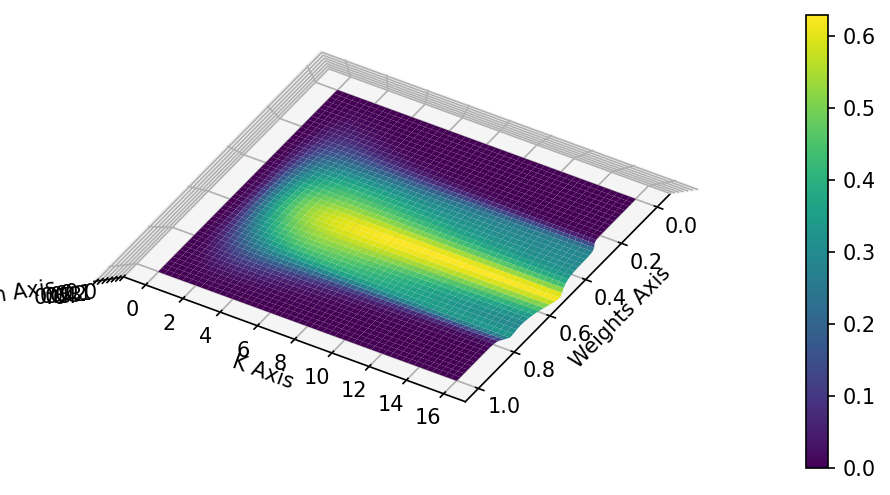

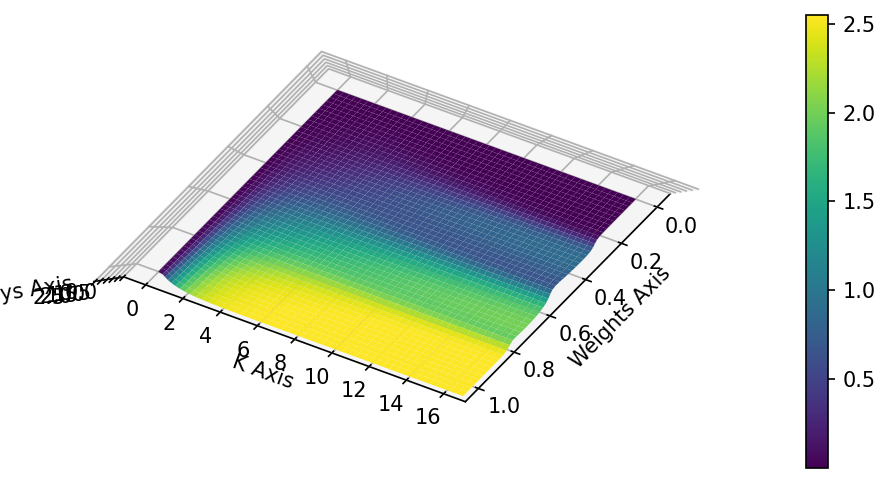

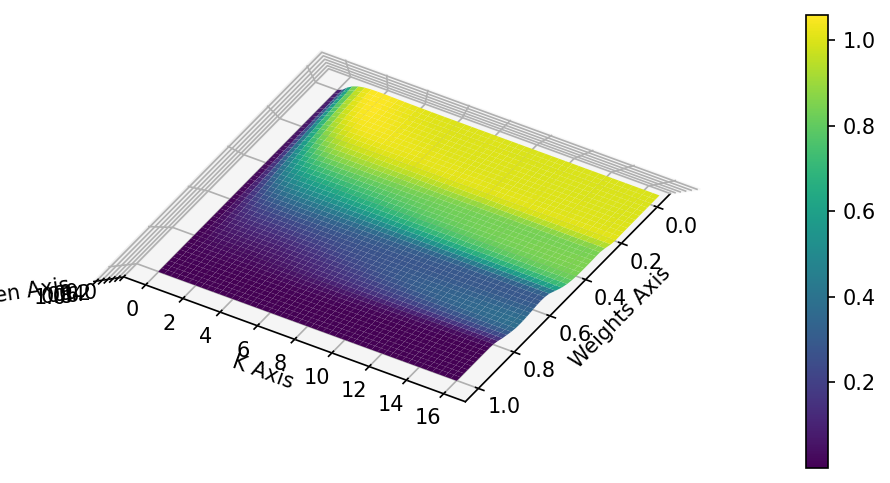

In [6]:
def plot_3d(axis1, axis2, measure, name=''):
    # 创建一个新的figure
    fig = plt.figure(figsize=(8,4), dpi=150)
    ax = fig.add_subplot(111, projection='3d')
    data = measure
    X, Y = np.meshgrid(axis1, axis2)
    Z = data
    surf = ax.plot_surface(X, Y, Z, cmap='viridis')
    fig.colorbar(surf)
    ax.set_xlabel('Weights Axis')
    ax.set_ylabel('K Axis')
    ax.set_zlabel(name + ' Axis')
    ax.view_init(elev=90, azim=30)
    plt.show()
    return

plot_3d(w_axis, k_axis, syn_arr, "syn")
plot_3d(w_axis, k_axis, un_sys_arr, "un_sys")
plot_3d(w_axis, k_axis, un_en_arr, "un_en")

In [ ]:
n = 50
syn_arr = np.zeros([n, n])
un_sys_arr = np.zeros([n, n])
un_en_arr = np.zeros([n, n])
w_axis = np.linspace(0, 1, n)
k_axis = np.linspace(0, 16, n)
for w_id,w in enumerate(w_axis):
    w2 = 1 - w
    ww = {
        'w_ab': w,
        'w_ba': w,
        'w_bc': w,
        'w_cb': w,
        'w_cd': w,
        'w_dc': w,
        'w_de': w,
        'w_ed': w,
        'w_ea': w,
        'w_ae': w,
        'w_a': w,
        'w_b': w,
        'w_c': w,
        'w_d': w,
        'w_e': w,
        'w1a': w2,
        'w1b': w2,
        'w1c': w2,
        'w1d': w2,
        'w1e': w2,
        'w2a': w2,
        'w2b': w2,
        'w2c': w2,
        'w2d': w2,
        'w2e': w2,
        'w3a': w2,
        'w3b': w2,
        'w3c': w2,
        'w3d': w2,
        'w3e': w2,
    }
    for k_id,k in enumerate(k_axis):
        tpm, tpm_v = make_tpm(bnet5, ww, k=k)
        un_sys, un_en, syn, tpm_dic = iit_tpm_cal(tpm_v, mech_size=5, en_size=3) 
        syn_arr[k_id, w_id] = syn
        un_sys_arr[k_id, w_id] = un_sys
        un_en_arr[k_id, w_id] = un_en

In [ ]:
def plot_3d(axis1, axis2, measure, name=''):
    # 创建一个新的figure
    fig = plt.figure(figsize=(8,4), dpi=150)
    ax = fig.add_subplot(111, projection='3d')
    data = measure
    X, Y = np.meshgrid(axis1, axis2)
    Z = data
    surf = ax.plot_surface(X, Y, Z, cmap='viridis')
    fig.colorbar(surf)
    ax.set_xlabel('Weights Axis')
    ax.set_ylabel('K Axis')
    ax.set_zlabel(name + ' Axis')
    #ax.view_init(elev=30, azim=30)
    plt.show()
    return

plot_3d(w_axis, k_axis, syn_arr, "syn")
plot_3d(w_axis, k_axis, un_sys_arr, "un_sys")
plot_3d(w_axis, k_axis, un_en_arr, "un_en")

# 梯径分析序列

In [3]:
import string

# 获取所有小写字母
lowercase_letters = list(string.ascii_lowercase)

# 获取所有大写字母
uppercase_letters = list(string.ascii_uppercase)

# 合并两个列表
all_letters = lowercase_letters + uppercase_letters



In [7]:
lens = 2000
init_state = '00111'
tpm1, tpm_v1 = make_tpm(bnet, w1, k=1)
for seed in range(3):
    serie, _ = tpm_series(tpm_v1, init_state, lens, seed)
    letter_list = [all_letters[i] for i in serie]
    with open('w1_'+init_state+'_'+str(seed)+'.txt', 'w') as f:
            f.write(''.join(letter_list))


In [8]:

tpm2, tpm_v2 = make_tpm(bnet, w2, k=1)
for seed in range(3):
    serie, _ = tpm_series(tpm_v2, init_state, lens, seed)
    letter_list = [all_letters[i] for i in serie]
    with open('w2_'+init_state+'_'+str(seed)+'.txt', 'w') as f:
            f.write(''.join(letter_list))